# Tugas Mandiri 1 – Eksplorasi DL Model Training
**Dito Rifki Irawan - 122140153**

Lakukan eksplorasi berbasis pada **Modul01** yang telah diberikan, terkait dengan proses pelatihan dari model **SimpleANN**.

Lakukan klasifikasi biner terhadap salah satu data dari library berikut dengan total jumlah data **500** (400 train set dan 100 test set):

- `sklearn.datasets.make_circles(noise=0.02)`

Anda diizinkan untuk mengubah arsitektur dari **SimpleANN**:
- Jumlah *hidden layer* dan jumlah *hidden neuron* pada setiap layer
- Fungsi aktivasi yang digunakan pada setiap *hidden layer*

Kumpulkan hasil eksplorasi dalam bentuk laporan **PDF** (hasil export dari Jupyter Notebook atau Google Colab) paling lambat **Jumat, 5 September 2025 pukul 23.59 WIB** pada E-Learning.


## Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_circles
from torchmetrics.classification import BinaryAccuracy
import pandas as pd
from helper import plot_scatter_with_boundary



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Data Preparation

In [3]:
torch.manual_seed(10)
num_data = 500
X, y = make_circles(n_samples=num_data, noise=0.02)

In [4]:
data = pd.DataFrame({
    "Feature 1": X[:, 0],
    "Feature 2": X[:, 1],
    "Class": y
})

data.head(10)

,Feature 1,Feature 2,Class
0,0.490800,0.880552,0
1,-0.735163,0.357568,1
2,0.952022,-0.252559,0
3,-0.221444,-0.997173,0
4,0.578757,0.597104,1
5,-0.303036,0.737742,1
6,-0.807051,-0.195362,1
7,-0.812158,0.584429,0
8,0.320546,0.689439,1
9,-1.001978,-0.179598,0


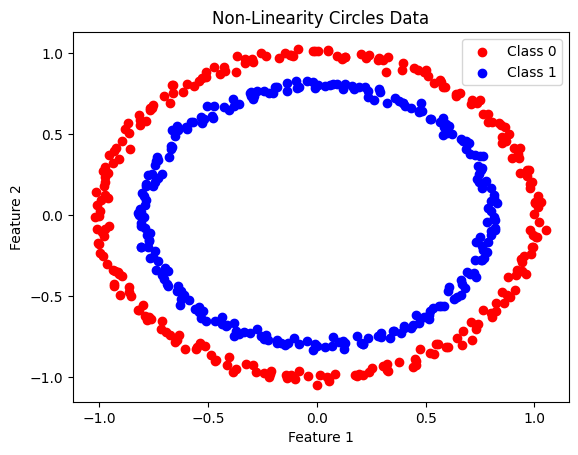

In [5]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1')
plt.title('Non-Linearity Circles Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [6]:
batch_size = 50
train_ratio = 0.8
train_size = int(train_ratio * num_data)

X_train_pt = torch.tensor(X[:train_size], dtype=torch.float32)
y_train_pt = torch.tensor(y[:train_size], dtype=torch.float32).unsqueeze(1)
X_test_pt = torch.tensor(X[train_size:], dtype=torch.float32)
y_test_pt = torch.tensor(y[train_size:], dtype=torch.int8).unsqueeze(1)
train_set = TensorDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

## Train Function

In [7]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().numpy()
        loss_history.append(running_loss/len(dataloader))
        if (epoch+1) % 5 == 0:
            print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    return loss_history


# Model 1

Arsitektur ANN pada Modul01 terdiri atas 2 hidden layer dengan kombinasi fungsi aktivasi ReLU → Tanh → Sigmoid.
- `Hidden Layer 1: ReLU`
- `Hidden Layer 2: Tanh`
- `Output Layer: Sigmoid`

dan ukuran hidden layer, yaitu hidden layer 1 dengan ukuran 10 neuron dan hidden layer 2 dengan ukuran 5 neuron.

In [8]:
class SimpleANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleANN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.fc2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, output_size)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

## Training Process

Epoch 5, Loss: 0.6934375762939453
Epoch 10, Loss: 0.6930214166641235
Epoch 15, Loss: 0.6934299468994141
Epoch 20, Loss: 0.692858099937439
Epoch 25, Loss: 0.692784309387207
Epoch 30, Loss: 0.6926637291908264
Epoch 35, Loss: 0.6923737525939941
Epoch 40, Loss: 0.6921223998069763
Epoch 45, Loss: 0.691997230052948
Epoch 50, Loss: 0.6919451951980591
Epoch 55, Loss: 0.6910753846168518
Epoch 60, Loss: 0.6906927824020386
Epoch 65, Loss: 0.6903414130210876
Epoch 70, Loss: 0.6895198822021484
Epoch 75, Loss: 0.6891571879386902
Epoch 80, Loss: 0.6882488131523132
Epoch 85, Loss: 0.6874145269393921
Epoch 90, Loss: 0.6862922310829163
Epoch 95, Loss: 0.6853523850440979
Epoch 100, Loss: 0.684199869632721


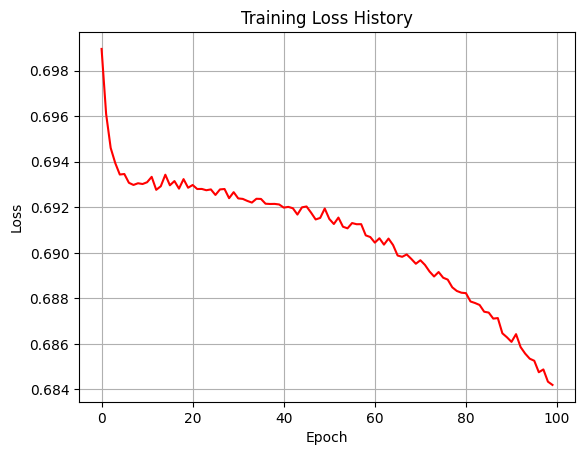

In [9]:
model_1 = SimpleANN(input_size=2, hidden_size1=10, hidden_size2=5, output_size=1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)
loss_train_history = train_model(model_1, train_loader, criterion, optimizer, epochs=100)

plt.plot(loss_train_history, color='red')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## Evaluate

In [10]:
model_1.eval()
with torch.no_grad():
    y_pred = model_1(X_test_pt)

metric = BinaryAccuracy(threshold=0.5)
accuracy = metric(y_pred, y_test_pt)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5199999809265137


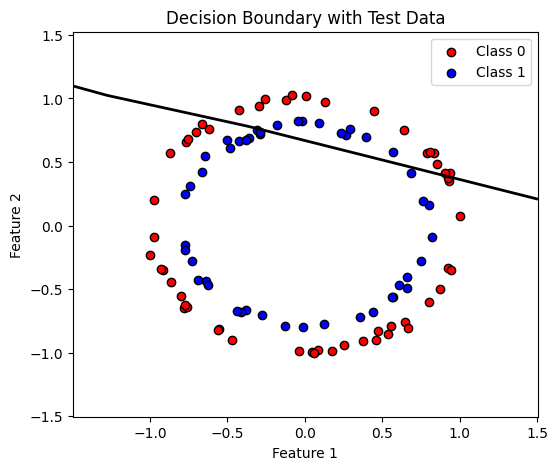

In [11]:
plot_scatter_with_boundary(model_1, X_test_pt, y_test_pt)

## Kesimpulan Model 1


Model SimpleANN dengan 2 hidden layer (10 neuron dan 5 neuron) menghasilkan akurasi sekitar 51%. Hasil ini menunjukkan performa model masih rendah dan hampir setara dengan tebakan acak pada klasifikasi biner (50%). Dari visualisasi decision boundary, terlihat bahwa model gagal memisahkan data dengan baik. Artinya, arsitektur dan parameter yang digunakan saat ini belum optimal untuk data tersebut.

Untuk meningkatkan performa, diperlukan perbaikan melalui penyesuaian jumlah layer dan hidden units, penambahan epoch, penggunaan fungsi aktivasi non-linear dan oprimizer yang lebih sesuai, pengaturan learning rate, serta pemilihan loss function yang tepat. **Karena pada Tugas Mandiri 1 diperbolehkan melakukan modifikasi arsitektur SimpleANN (jumlah hidden layer, hidden neuron, dan fungsi aktivasi), maka fokus penyesuaian akan diarahkan pada aspek-aspek tersebut.**

# Model 2

Pada Model kedua, tidak ada penambahan layer maupun perubahan arsitektur. Perbedaan hanya terletak pada penyesuaian ukuran hidden layer, yaitu hidden layer 1 menjadi 32 neuron dan hidden layer 2 menjadi 10 neuron.

## Training Process

Epoch 5, Loss: 0.6933212280273438
Epoch 10, Loss: 0.6913509368896484
Epoch 15, Loss: 0.6904321312904358
Epoch 20, Loss: 0.688882052898407
Epoch 25, Loss: 0.6866753697395325
Epoch 30, Loss: 0.6831536889076233
Epoch 35, Loss: 0.6792077422142029
Epoch 40, Loss: 0.6749023199081421
Epoch 45, Loss: 0.668854296207428
Epoch 50, Loss: 0.6606180667877197
Epoch 55, Loss: 0.6501399278640747
Epoch 60, Loss: 0.6350514888763428
Epoch 65, Loss: 0.6162831783294678
Epoch 70, Loss: 0.5909376740455627
Epoch 75, Loss: 0.5538293123245239
Epoch 80, Loss: 0.5035678148269653
Epoch 85, Loss: 0.45460769534111023
Epoch 90, Loss: 0.3642890751361847
Epoch 95, Loss: 0.31762051582336426
Epoch 100, Loss: 0.24318234622478485


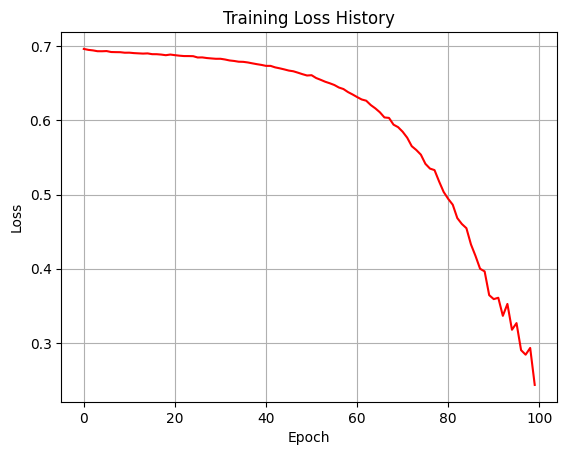

In [12]:
model_2 = SimpleANN(input_size=2, hidden_size1=32, hidden_size2=10, output_size=1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)
loss_train_history = train_model(model_2, train_loader, criterion, optimizer, epochs=100)

plt.plot(loss_train_history, color='red')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Evaluate

In [13]:
model_2.eval()
with torch.no_grad():
    y_pred = model_2(X_test_pt)

metric = BinaryAccuracy(threshold=0.5)
accuracy = metric(y_pred, y_test_pt)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


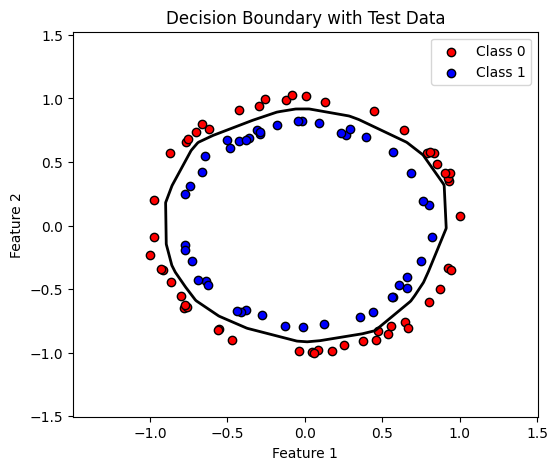

In [14]:
plot_scatter_with_boundary(model_2, X_test_pt, y_test_pt)

## Kesimpulan Model 2

Model SimpleANN dengan dua hidden layer (32 neuron dan 10 neuron) menunjukkan performa yang sangat baik dengan akurasi mencapai 100%. Hal ini terlihat dari penurunan loss yang konsisten selama proses training, serta decision boundary yang terbentuk sesuai dengan pola data uji. Artinya, penyesuaian jumlah neuron pada hidden layer membuat model mampu mempelajari pola data dengan optimal dan mengklasifikasikan dengan sangat akurat.

# Referensi
https://www.learnpytorch.io/02_pytorch_classification/